In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

whole_data = pd.read_csv('/content/train.csv')
df = whole_data.copy()
data = df.drop(['SalePrice'], axis=1)
target = df['SalePrice']

categorical_columns = data.describe(include=[object]).T.index
numeric_columns = data.describe(include=[np.number]).T.index

# Feature selection (searching features that can be dropped)
The idea is that due to the large number of features in the original dataset (80, not including the target), it might be beneficial to reduce the number of features. We do this in differnet ways:

##Highly correlated numerical features
We looked for highky correlated features and decided to drop one of each pair:

In [2]:
# Finding highly-correlated pairs of features (should be dropped?)
num_corr = data[numeric_columns].corr()
correlation_matrix = data[numeric_columns].corr()
threshold = 0.7
highly_correlated_numeric_features = []

for i in range(len(numeric_columns)):
  for j in range(i+1, len(numeric_columns)):
    feature1 = numeric_columns[i]
    feature2 = numeric_columns[j]
    correlation = correlation_matrix.iloc[i,j]

    if correlation > threshold:
      highly_correlated_numeric_features.append((feature1, feature2, round(correlation, 3)))

print(highly_correlated_numeric_features)

[('YearBuilt', 'GarageYrBlt', 0.826), ('TotalBsmtSF', '1stFlrSF', 0.82), ('GrLivArea', 'TotRmsAbvGrd', 0.825), ('GarageCars', 'GarageArea', 0.882)]


In [3]:
#features to drop due to high correlation with another feature (one from each pair):
# we drop features that are not common to all samples (e.g., all buildings must have YearBuilt but not necessarily GarageYrBlt)
high_correlated_features_to_drop = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars']

##Correlation of categorical object type features with the target
By plotting the categorical distributions of each (categorical) feature with respect to the target, we can choose specific features that seem to hold few meaningful information (mostly features with approximately uniform distribution or highly imbalanced distribtion).

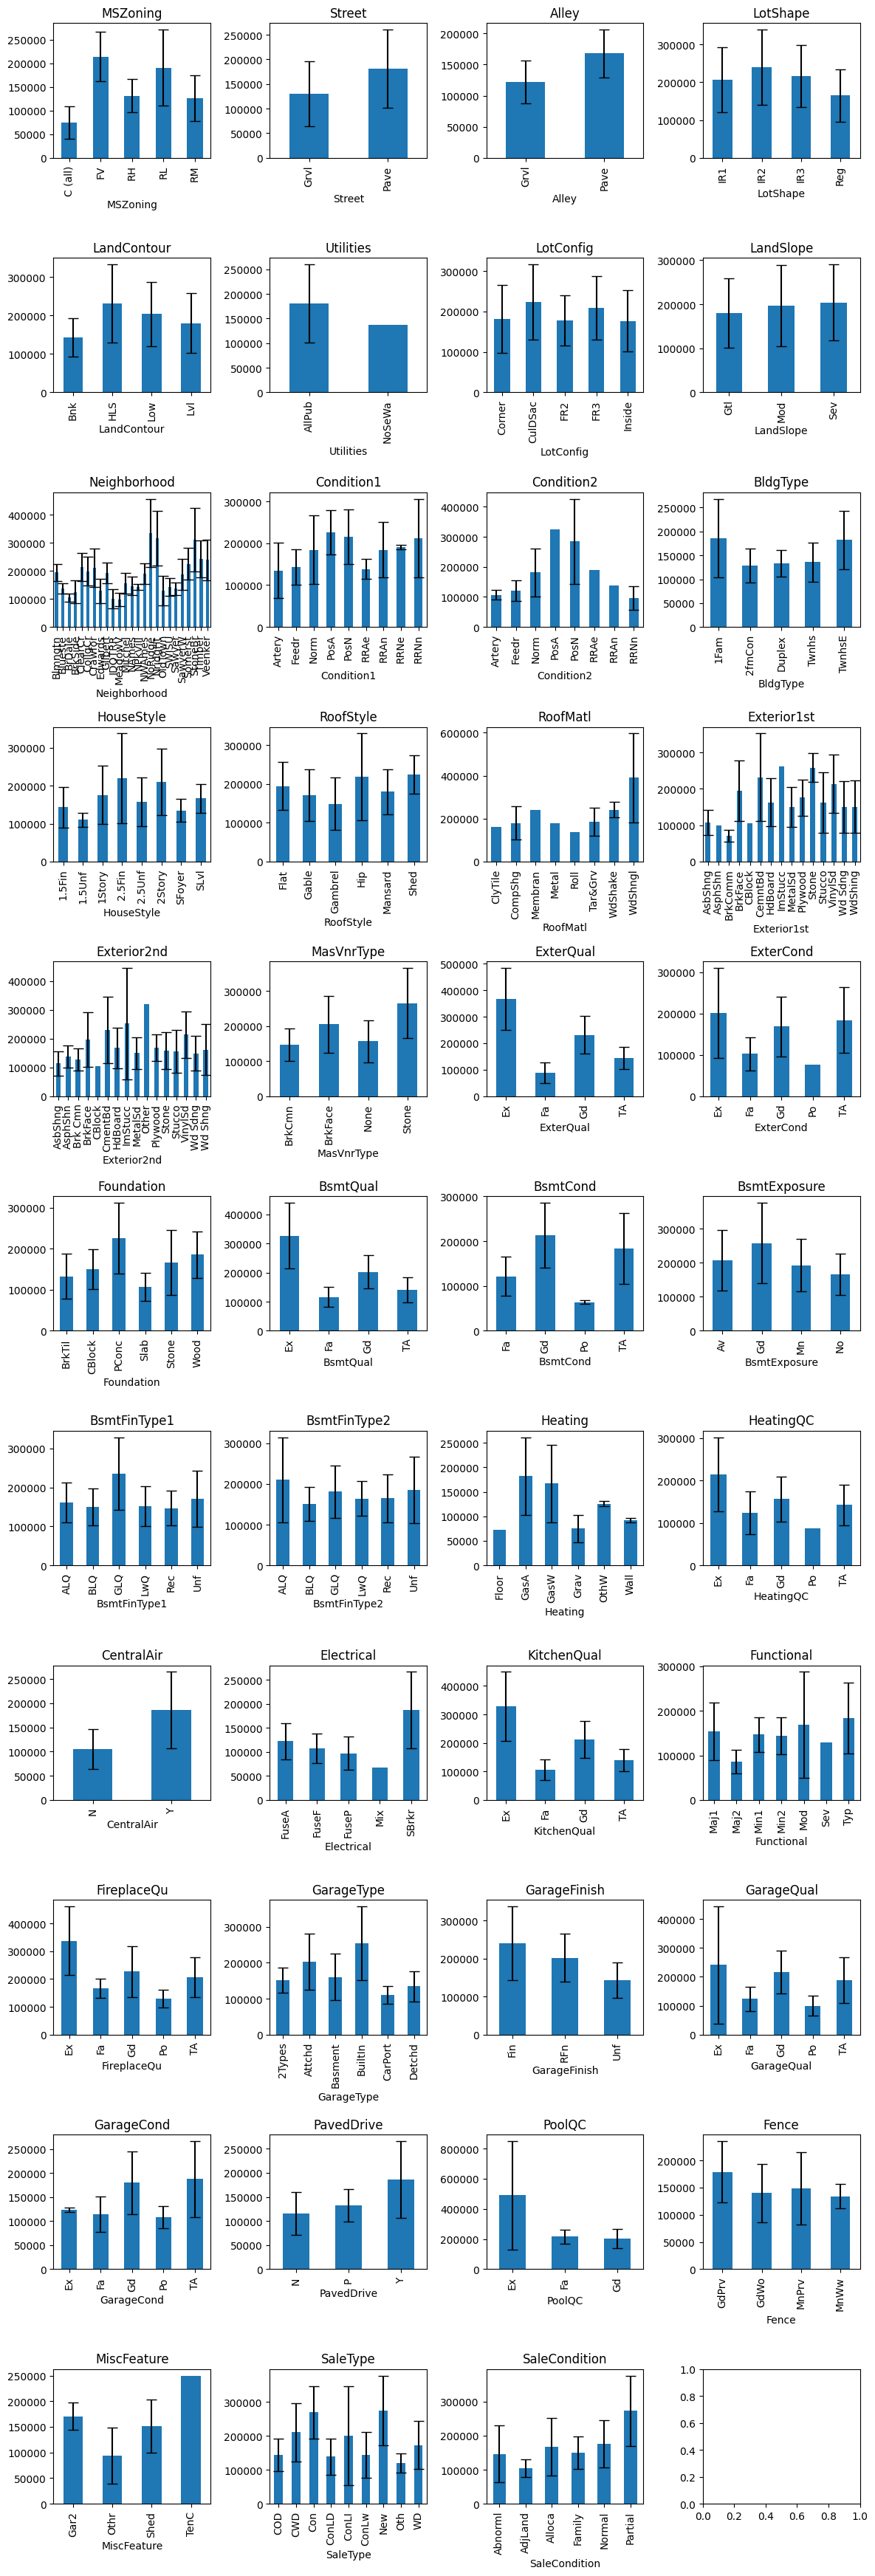

In [4]:
# Finding correlation (indirectly) between 'object' features and target:
fig, axes = plt.subplots(11,4, figsize=(12,35))
for i, column in enumerate(categorical_columns):
  target_mean = df.groupby(column)['SalePrice'].mean()

  target_std = df.groupby(column)['SalePrice'].std()

  cur_ax = axes[i // 4, i % 4]
  target_mean.plot(kind='bar', ax=cur_ax, yerr=target_std, capsize=5)
  cur_ax.set_title(column)
plt.tight_layout()
plt.show()

In [5]:
# Object features that show low correlation to target (by indirect impresion):
cat_cols_uncor_w_target = ['LotShape', 'LandContour', 'LotConfig',
                           'LandSlope', 'Condition2', 'RoofMatl', 'BsmtExposure',
                           'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                           'Functional', 'Fence', 'MiscFeature'
                           ]

##Numerical features with imbalanced data

In [6]:
#numerical features to drop due to high imbalance of the data:
drop_imbalanced = ['Heating', 'Alley', 'Street', 'Utilities']


In [7]:
# features with NaN values that relflect 'None' and should not be discraded (should be counted):
convert_nan_to_str = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageType',
                      'GarageFinish', 'GarageQual', 'GarageCond'
                      ]

# features with same problem, but were already dropped due to other reason:
#['BsmtExposure', 'BsmtFinType1', 'PoolQC', 'MiscFeature]

In [8]:
# filtering the data frame according to selected features to drop:
filtered_df = df.drop(high_correlated_features_to_drop, axis=1)
filtered_df = filtered_df.drop(cat_cols_uncor_w_target, axis=1)
filtered_df.drop(drop_imbalanced, axis=1, inplace=True)

for feature in convert_nan_to_str:
  filtered_df[feature].fillna(value='No', inplace=True)

##Feature engineering on pool information

In [9]:
# only 7 samples with pool, but might be important, so:
# we create new *binary* feature 'HavePool' and drop 'PoolQC' 'PoolArea'

filtered_df['HavePool'] = filtered_df['PoolArea']
filtered_df.loc[filtered_df['HavePool'] != 0, 'HavePool'] = 1
filtered_df.loc[filtered_df['HavePool'] == 0, 'HavePool'] = 0
filtered_df.drop(['PoolArea', 'PoolQC'], axis=1, inplace=True)

#Treating missing values

In [10]:
# replacing missing values in 'LotFrontage' with mean values:
mean_value_LotFrontage = filtered_df['LotFrontage'].mean()
filtered_df['LotFrontage'].fillna(value=mean_value_LotFrontage, inplace=True)